In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from agents.maddpg_agent import MADDPGAgent
from config.config import Config

%matplotlib inline

In [2]:
config = Config()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
def print_env_information(config):
    config.env_info = config.env.reset(train_mode=False)[config.brain_name]
    config.num_agents = len(config.env_info.agents)
    print('Number of agents:', config.num_agents)
    print('Size of each action:', config.action_dim)
    config.states = config.env_info.vector_observations
    print('There are {} agents. Each observes a state with length: {}'.format(config.states.shape[0], config.state_dim))
    print('The state for the first agent looks like:', config.states[0])


def run_random_env(config):
    env_info = config.env.reset(train_mode=False)[config.brain_name]
    states = env_info.vector_observations
    scores = np.zeros(config.num_agents)
    steps = 1
    while True:
        actions = np.random.randn(config.num_agents, config.action_dim)
        actions = np.clip(actions, -1, 1)
        env_info = config.env.step(actions)[config.brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            print('Scores:')
            print(scores)
            # print('Environment done after {} steps'.format(t))
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [4]:
print_env_information(config)
run_random_env(config)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]
Scores:
[-0.01  0.1 ]
Total score (averaged over agents) this episode: 0.04500000085681677


## MADDPG
In the `maddpg_agent.py`, `maddpg_actor.py` and the `maddpg_critic.py` is the setup for the MADDPG algorithm. You can train your own agent and save the weights when you run the `run_maddpg.py`.
The small run script trains the agent and saves the weights every 20 episodes and the final weights. Also the score is saved in a numpy file. In the following I will load the saved weights and scores to show the performance

In [5]:
agent1 = MADDPGAgent(config, 0)
agent2 = MADDPGAgent(config, 1)
agent1.load_weights(3203)
agent2.load_weights(3203)

In [6]:
def run_agent():
    env_info = config.env.reset(train_mode=True)[config.brain_name]
    states = env_info.vector_observations
    scores = np.zeros(config.num_agents)
    while True:
        action1 = agent1.act(states[0], add_noise=False)
        action2 = agent2.act(states[1], add_noise=False)
        actions = np.vstack((action1, action2))
        env_info = config.env.step(actions)[config.brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores = np.add(scores, np.asarray(rewards))

        states = next_states

        if np.any(dones):
            break
    agent1.noise.reset()
    agent2.noise.reset()
    print(scores)
    print("Max score this episode from 2 agents: >> {:.2f} <<".format(scores.max()))

The agents do sometimes still have only a low score. Refresh the `run_agent()` cell until you get a higher score

In [11]:
run_agent()

[2.60000004 2.60000004]
Max score this episode from 2 agents: >> 2.60 <<


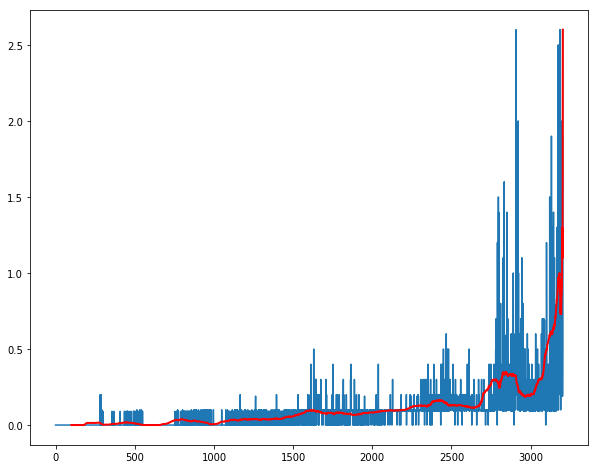

In [34]:
scores = np.load('weights/maddpg/maddpg_final.npy')
maxes = scores.max(axis=1)
mins = scores.min(axis=1)

means_l = []
for i in range(len(scores)):
    if i >= 100:
        mean_of_max = np.mean(maxes[i:i+100])
        means_l.append(mean_of_max)

means = np.asarray(means_l)
x = np.arange(len(scores))
x_mean = np.arange(100,len(means)+100)
fig, axs = plt.subplots(1, 1, figsize=(10,8))

axs1 = plt.plot(x, maxes)
axs1 = plt.plot(x_mean, means, color='red', linewidth=2)
# axs1 = plt.scatter(x, maxes)

In [35]:
config.env.close()